## In this plot, we make the 2d color color contour in different redshift bins

In [1]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches
from desi_lowz_funcs import sdss_rgb


In [7]:

import scipy.optimize as opt


def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level
    
def plot_2d_dist(x,y, nxbins, nybins, 
                cmin=1.e-4, cmax=1.0, smooth=None, clevs=None,ax=None):
    """
    construct and plot a binned, 2d distribution in the x-y plane 
    using nxbins and nybins in x- and y- direction, respectively
    
    log = specifies whether logged quantities are passed to be plotted on log-scale outside this routine
    """
    
    weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(-0.5, 1.5, nxbins),np.linspace(-0.5, 1.5, nybins)))
    
    H = np.rot90(H); H = np.flipud(H); 
             
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 

    if smooth != None:
        from scipy.signal import wiener
        H = wiener(H, mysize=smooth)
        
    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)

    pcol = ax.pcolormesh(X, Y,(Hmask),cmap=plt.cm.BuPu, norm = LogNorm(vmin=cmin*np.max(Hmask), vmax=cmax*np.max(Hmask) ), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')
        
    # plot contours if contour levels are specified in clevs 
    contour_paths = []
    if clevs is not None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
        
        cs = ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls), 
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])

        # Save contour paths
        contour_paths = [c for c in cs.collections]

    return contour_paths
    

In [12]:


from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde

def get_gmm(ax,gr_cols, rz_cols,
           contour_cmap = "viridis",hist_cmap = "Reds",
            hist_alpha = 1, cont_alpha = 1,contour_col = "r"):
    
    data = np.vstack( [gr_cols, rz_cols] )
    
    # Create a grid for evaluation
    xmin, xmax = -0.5, 2
    ymin, ymax = -0.5, 1.5
    X, Y = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    # Fit GMM with 3 components (change as needed)
    gmm = GaussianMixture(n_components=10, covariance_type='full')
    gmm.fit(data.T)
    
    # Evaluate the density on the grid
    Z_gmm = np.exp(gmm.score_samples(positions.T)).reshape(X.shape)
    
    ax.hist2d(gr_cols, rz_cols,bins=100,norm=LogNorm(),cmap = hist_cmap,alpha=hist_alpha )

    ## now compute the 2d quantiels

    Z_gmm = Z_gmm/np.sum(Z_gmm)        
    # plot contours if contour levels are specified in clevs 
    lvls = []
    
    clevs = [0.383,0.68,0.954,0.987]
    for cld in clevs:  
        sig = opt.brentq( conf_interval, 0., 1., args=(Z_gmm,cld) )   
        lvls.append(sig)

    if contour_cmap is None:
        ax.contour(X, Y, Z_gmm, levels=sorted(lvls), colors = contour_col,alpha = cont_alpha)
    else:
        ax.contour(X, Y, Z_gmm, levels=sorted(lvls), cmap=contour_cmap,alpha = cont_alpha)

    ax.set_xlim([-0.5,2])
    ax.set_ylim([-0.5,1.5])

    return gmm

def make_color_contour_plot():
    '''
    Plot that makes the g-r vs. r-z color contours for this distribution
    '''
    
    iron_data = Table.read("/pscratch/sd/v/virajvm/catalog/Iron_bgs_bright_all_phot_final_filter.fits")

    #redshift grid
    zgrid = np.arange(0.001, 0.525,0.025)
    
    fig,ax = make_subplots(ncol = 4, nrow = 1,return_fig=True,col_spacing=0.6)
    
    fsize = 20
    for j,i in enumerate([0,2,4,6]):
        print(j)
        
        iron_i = iron_data[ (iron_data["Z"]  > zgrid[i]) & (iron_data["Z"] < zgrid[i+1]) & (iron_data["DELTACHI2"] > 40)]
        gr_cols_i = iron_i["MAG_G"] - iron_i["MAG_R"] 
        rz_cols_i = iron_i["MAG_R"] - iron_i["MAG_Z"] 
    
        gmm_s = get_gmm(ax[j],gr_cols_i, rz_cols_i,contour_cmap = None,hist_cmap = "Greys",
                hist_alpha = 1, cont_alpha = 0.625,contour_col="darkorange")
    
        ax[j].set_xlabel(r"$g-r$",fontsize = fsize)
        ax[j].set_xticks([-0.5,0,0.5,1,1.5,2])
    
        #add the text inside
        ax[j].text(0.5,0.95,r"$%.3f < z < %.3f$"%(zgrid[i], zgrid[i+1]),color = "k",size=fsize-2,
                   transform=ax[j].transAxes, verticalalignment='top', horizontalalignment="center")
        
        if j != 0:
            ax[j].set_yticklabels([])
    
        # plot_2d_dist(gr_cols_i,rz_cols_i, 100, 100, 
        #         cmin=1.e-4, cmax=1.0, smooth=2,clevs=[0.383,0.68,0.954,0.987], ax=ax2[j])
    
    ax[0].set_ylabel(r"$r-z$",fontsize = fsize)
    
    plt.savefig("plots/gr_rz_zred_dists.pdf",bbox_inches="tight")
    plt.show(fig)

    return


0
1
2
3


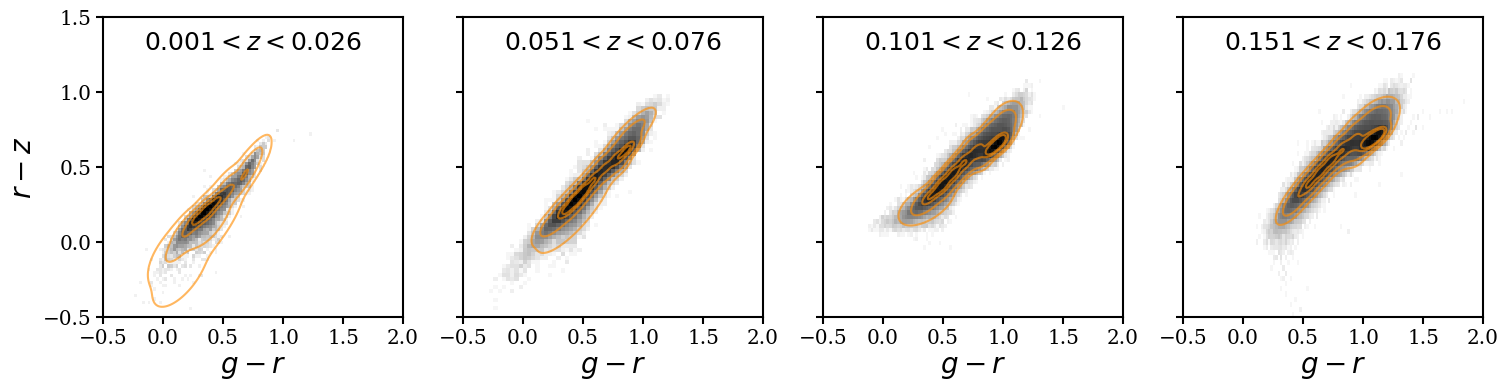

In [13]:
make_color_contour_plot()